In [ ]:
%load_ext watermark
%watermark


In [ ]:
import pandas as pd

import numpy as np

import seaborn as sns

from ipywidgets import interact, FloatSlider, IntSlider, fixed

from IPython.display import display

from scipy import stats

import pickle

from datetime import datetime

from progressbar import ProgressBar

import matplotlib.pyplot as plt

import os

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.python.platform import build_info as build
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop

from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Dropout
from keras.callbacks import TensorBoard
from keras.constraints import maxnorm

sns.set(font_scale=0.7)


# Resume

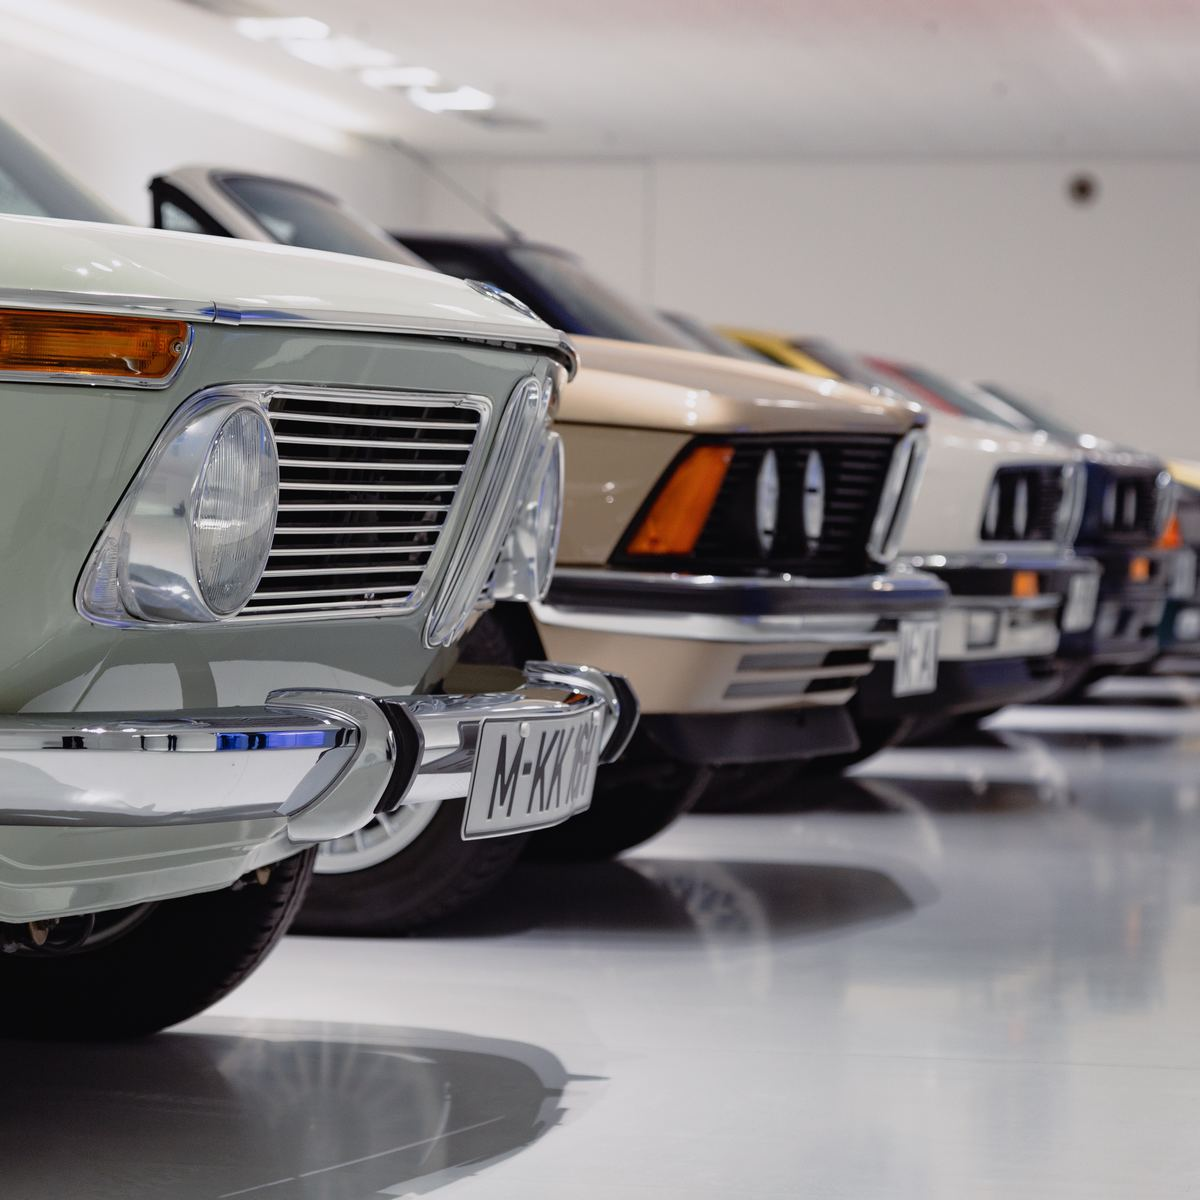

# Data Collection

In [ ]:
df = pd.read_csv('_resources/vehicles_us.csv', parse_dates=['date_posted'])
df.head()


In [ ]:
df.info()


# Data Wrangling

In [ ]:
#


In [ ]:
target_column = 'price'


# Data Visualization

In [ ]:
def update_datatypes_columns():
    numeric_features = df.select_dtypes(include=np.number).columns.to_list()

    continuous_features = df.select_dtypes(include=float).columns.to_list()

    discrete_features = df.select_dtypes(include=int).columns.to_list()

    categorical_features = df.select_dtypes(
        include='category').columns.to_list()

    object_features = df.select_dtypes(include='object').columns.to_list()

    bool_features = df.select_dtypes(include=bool).columns.to_list()

    date_time_features = df.select_dtypes(
        include=np.datetime64).columns.to_list()

    time_delta_features = df.select_dtypes(
        include=np.timedelta64).columns.to_list()

    display({'numeric_features': ', '.join(numeric_features), 'continuous_features': ', '.join(continuous_features),
             'discrete_features': ', '.join(discrete_features), 'categorical_features': ', '.join(categorical_features),
             'object_features': ', '.join(object_features), 'bool_features': ', '.join(bool_features),
             'date_time_features': ', '.join(date_time_features), 'time_delta_features': ', '.join(time_delta_features)})

    return numeric_features, continuous_features, discrete_features, categorical_features, \
        object_features, bool_features, date_time_features, time_delta_features


numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()


## Statistical Summary

In [ ]:
df.describe()


## Correlation

### Dispersion Diagram

In [ ]:
@interact(hue=[None] + categorical_features + bool_features,
          size=[None] + numeric_features,
          n_samples=IntSlider(value=10000, min=10000, max=50000, step=1000))
def _(hue, size, n_samples):

    if hue != None and len(df[hue].unique()) > 20:
        print(f'Too many categories: {hue}={df[hue].unique()}')
        return

    _df = df.sample(n=n_samples, replace=False, random_state=23)

    sns.pairplot(data=_df, hue=hue, size=size, diag_kind='hist')

    plt.show()


In [ ]:
@interact(x=numeric_features,
          y=numeric_features,
          hue=[None] + categorical_features + bool_features,
          size=[None] + numeric_features,
          style=[None] + categorical_features + bool_features,
          alpha=FloatSlider(value=1, min=.1, max=1, step=.1),
          show=fixed(True), file_name=fixed(''))
def my_relplot(x, y, hue, size, style, alpha, show, file_name):

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    if style != None and len(df[style].unique()) > 50:
        if show == True:
            print(f'Too many categories: {style}={df[style].unique()}')

        return

    chart = sns.relplot(data=df, x=x, y=y, hue=hue, size=size,
                        style=style, alpha=alpha, height=6)

    plt.title(f'{x} vs {y}', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


In [ ]:
@interact(x=numeric_features,
          y=categorical_features + bool_features,
          hue=[None] + categorical_features + bool_features,
          orient=['v', 'h'],
          n_samples=IntSlider(value=1000, min=1000, max=50000, step=1000),
          show=fixed(True), file_name=fixed(''))
def my_swarmplot(x, y, hue, orient, n_samples, show, file_name):

    plt.rcParams['figure.figsize'] = (18, 6)

    if y == None:
        print('No existen variables categóricas o booleanas.')
        return

    if len(df[y].unique()) > 50:
        if show == True:
            print(f'Too many categories: {y}={df[y].unique()}')

        return

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    _df = df.sample(n=n_samples, replace=True, random_state=23)

    if orient == 'v':
        x, y = y, x

    chart = sns.swarmplot(data=_df, x=x, y=y, hue=hue, orient=orient, size=3)

    plt.title(f'{y} by {x}', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


### Pearson Correlation

In [ ]:
@interact(show=fixed(True), file_name=fixed(''))
def my_pearson(show, file_name):

    plt.rcParams['figure.figsize'] = (10, 10)

    matrix = df.corr(method='pearson', numeric_only=True)
    chart = sns.heatmap(data=matrix, annot=True, square=True, center=0)
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45, horizontalalignment='right')

    plt.title('Pearson Diagram', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


## Distributions

### Histogram

In [ ]:
@interact(col=numeric_features,
          normal=False,
          stat=['count', 'frequency', 'probability', 'percent', 'density'],
          cumulative=False,
          hue=[None] + categorical_features + bool_features,
          kde=False,
          show=fixed(True), file_name=fixed(''))
def my_histplot(col, normal, stat, cumulative, hue, kde, show, file_name):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6),
                           gridspec_kw={'width_ratios': [1, .3]})

    # ax1 -----------------------------------------------------------------------------------

    if normal == False:
        if hue != None and len(df[hue].unique()) > 50:
            if show == True:
                print(f'Too many categories: {hue}={df[hue].unique()}')

            plt.close()
            return

        chart = sns.histplot(data=df, ax=ax[0], x=col, hue=hue, stat=stat,
                             multiple='stack', cumulative=cumulative, kde=kde)
        chart.set(title='Histogram')
    else:
        try:
            # Valores de la media (mu) y desviación típica (sigma) de los datos
            mu, sigma = stats.norm.fit(data=df[col])

            chart = sns.histplot(data=df, ax=ax[0], x=col, stat='density')

            # Valores teóricos de la normal en el rango observado
            x_hat = np.linspace(min(df[col]), max(df[col]), num=100)
            y_hat = stats.norm.pdf(x_hat, mu, sigma)

            ax[0].plot(x_hat, y_hat, 'r', linewidth=2, label='normal')
            ax[0].legend()
        except Exception as e:
            chart = sns.histplot(data=df, ax=ax[0], x=col, stat=stat)
            print('ax_0 error:', e)

    # ax2 -----------------------------------------------------------------------------------

    try:
        fig = sm.qqplot(df[col], fit=True, line='q', alpha=0.4, lw=2, ax=ax[1])
    except Exception as e:
        print('ax_1 error:', e)

    # ---------------------------------------------------------------------------------------

    if show == False:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()
        return

    kurtosis, skew = stats.kurtosis(df[col]), stats.skew(df[col])
    kurtosis, skew = round(kurtosis, 2), round(skew, 2)

    if skew < -1 or skew > 1:
        print(f'- La distribución está muy sesgada (skew={skew}).')
    elif -1 <= skew < -0.5 or 0.5 < skew <= 1:
        print(f'- La distribución está moderadamente sesgada (skew={skew}).')
    elif -0.5 <= skew <= 0.5:
        print(f'- La distribución es aproximadamente simétrica (skew={skew}).')

    if kurtosis < -0.5:
        print(
            f'- La distribución platicúrtica (kurtosis={kurtosis}), ', end='')
        print('existe una baja concentración de los valores en torno a su media.')
    if kurtosis > 0.5:
        print(f'- La distribución leptocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una gran concentración de los valores en torno a su media.')
    if -0.5 <= kurtosis <= 0.5:
        print(f'- La distribución mesocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una concentración normal de los valores en torno a su media.')

    plt.show()


### Probability Mass Function (PMF)

In [ ]:
@interact(column=discrete_features, normalize=False)
def my_pmf(column, normalize):

    if column == None:
        print('No existen variables discretas.')
        return

    plt.rcParams['figure.figsize'] = (10, 6)

    data = df[column].value_counts(normalize=normalize)

    data = pd.DataFrame({'INDEX': data.index,
                         'VALUE': data.values}).sort_values(by=['INDEX'])

    plt.plot(data['INDEX'], data['VALUE'], '--')
    plt.vlines(data['INDEX'], 0, data['VALUE'], colors='b', lw=5, alpha=0.5)

    plt.title('Función de Masa de Probabilidad', fontsize=12)
    plt.ylabel('Density' if normalize else 'Count')
    plt.xlabel(column)
    plt.show()


In [ ]:
@interact(x=numeric_features,
          y=numeric_features,
          hue=[None] + categorical_features + bool_features,
          kind=['scatter', 'kde', 'hist', 'hex', 'reg', 'resid'],
          show=fixed(True), file_name=fixed(''))
def my_jointplot(x, y, hue, kind, show, file_name):

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    chart = sns.jointplot(data=df, x=x, y=y, hue=hue, kind=kind, height=6)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


### Box - Violin Plot

In [ ]:
@interact(col=[None] + numeric_features,
          violin=False,
          orient=['v', 'h'],
          show=fixed(True), file_name=fixed(''))
def my_boxplot(col, violin, orient, show, file_name):

    if col is None:
        plt.rcParams['figure.figsize'] = (16, 8)
    else:
        plt.rcParams['figure.figsize'] = (6, 2)

    if violin:
        chart = sns.violinplot(data=df, x=col, orient=orient)
        plt.title('Violin Plot', fontsize=12)
    else:
        chart = sns.boxplot(data=df, x=col, orient=orient)
        plt.title('Box Plot', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


In [ ]:
@interact(x=categorical_features + bool_features,
          y=numeric_features,
          hue=[None] + bool_features,
          violin=False,
          split=False,
          orient=['v', 'h'],
          show_points=False,
          show=fixed(True), file_name=fixed(''))
def my_violinplot(x, y, hue, violin, split, orient, show_points, show, file_name):

    if x == None:
        print('No existen variables categóricas o booleanas.')
        return

    if len(df[x].unique()) > 50:
        if show == True:
            print(f'Too many categories: {x}={df[x].unique()}')

        return

    x_org = x
    if orient == 'h':
        x, y = y, x

    if show_points == True:
        chart = sns.stripplot(data=df, x=x, y=y, color='.3', size=3)

    plt.rcParams['figure.figsize'] = (10, 6)

    if violin:
        chart = sns.violinplot(x=x, y=y, data=df, hue=hue,
                               split=split, orient=orient)
        plt.title(f'Violin Plot by {x_org}', fontsize=12)
    else:
        chart = sns.boxplot(x=x, y=y, data=df, hue=hue, orient=orient)
        plt.title(f'Box Plot by {x_org}', fontsize=12)

    sns.despine(offset=10, trim=True)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


## Contingency Table

In [ ]:
@interact(index=categorical_features + bool_features,
          columns=categorical_features + bool_features,
          values=numeric_features,
          annot=False,
          agg_func=['count', 'mean', 'median', 'sum', 'std', 'probability'],
          show=fixed(True), file_name=fixed(''))
def my_contingency(index, columns, values, annot, agg_func, show, file_name):

    plt.rcParams['figure.figsize'] = (8, 8)

    if index == None:
        print('No existen variables categóricas.')
        return

    if index == columns:
        sns.displot(data=df, x=index)
        plt.show()
        return

    if len(df[index].unique()) > 50:
        if show == True:
            print(f'Too many categories: {index}={df[index].unique()}')

        return

    if len(df[columns].unique()) > 50:
        if show == True:
            print(f'Too many categories: {columns}={df[columns].unique()}')

        return

    agg_func_aux = 'count' if agg_func == 'probability' else agg_func
    contingency_table = df.pivot_table(index=index, columns=columns, values=values,
                                       aggfunc=agg_func_aux, fill_value=0).dropna(axis=0, how='all')

#     display(contingency_table)

    if agg_func == 'probability':
        contingency_table = contingency_table.astype(float).div(contingency_table.sum(axis=1),
                                                                axis=0)
        fmt = '.2%'
    else:
        fmt = 'g'

    chart = sns.heatmap(data=contingency_table,
                        annot=annot, fmt=fmt, square=True)
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45, horizontalalignment='right')

    if agg_func == 'count':
        plt.title(f'Contingency Table ({agg_func})', fontsize=12)
    else:
        plt.title(f'Contingency Table ({agg_func} {values})', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


## Statistics

In [ ]:
@interact(x=categorical_features + bool_features,
          y=numeric_features,
          hue=[None] + categorical_features + bool_features,
          estimator=['mean', 'count', 'median', 'sum', 'std'],
          kind=['bar', 'strip', 'box', 'violin', 'boxen', 'point'],
          orient=['v', 'h'],
          show=fixed(True), file_name=fixed(''))
def my_catplot(x, y, hue, estimator, kind, orient, show, file_name):

    if x == None:
        print('No existen variables categóricas.')
        return

    if len(df[x].unique()) > 50:
        if show == True:
            print(f'Too many categories: {x}={df[x].unique()}')

        return

    if hue != None and len(df[hue].unique()) > 5:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    if orient == 'h':
        x, y = y, x

    chart = sns.catplot(data=df, x=x, y=y, hue=hue, estimator=estimator, kind=kind,
                        orient=orient, errorbar=None, height=6, aspect=2.5)
    chart.despine(left=True)

    if estimator == 'count':
        chart.set(ylabel='count')

    plt.title(f'Statistics ({estimator})', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


In [ ]:
@interact(col=categorical_features, show=fixed(True), file_name=fixed(''))
def my_pie(col, show, file_name):

    if col == None:
        print('No existen variables categóricas.')
        return

    plt.rcParams['figure.figsize'] = (8, 8)

    labels = df[col].value_counts().index.values
    sizes = df[col].value_counts().values
    explode = np.full(df[col].value_counts().count(), 0.1)

    _, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.axis('equal')

    plt.title(f'{col}', fontsize=12)

    if show == True:
        plt.show()
    else:
        plt.savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


## Time

In [ ]:
@interact(x=date_time_features,
          y=numeric_features,
          agg_func=['count', 'mean', 'median', 'sum'],
          hue=[None] + categorical_features + bool_features,
          style=0,
          show=fixed(True), file_name=fixed(''))
def my_lineplot(x, y, agg_func, hue, style, show, file_name):
    if x == None:
        print('No existen variables de tiempo.')
        return

    if hue is not None and len(df[hue].unique()) > 20:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    plt.figure(figsize=(18, 8))

    by = [hue, x] if hue is not None else x
    data = df.groupby(by)[y].agg(agg_func).reset_index()

#     display(data.head())

    chart = sns.lineplot(data=data, x=x, y=y, hue=hue,
                         style=hue if style == True else None, linewidth=0.5)

    if agg_func == 'count':
        chart.set(ylabel='count')

    plt.title(f'Daily ({agg_func})', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'_resources/EDA/{file_name}.png')
        plt.close()


## Map

In [ ]:
#


# Data Cleaning & Transform

In [ ]:
n = df.shape[0]

# Completely empty rows are removed.
# In case you want to delete the row if any of its values is missing, use 'any' in the 'how' parameter
# Use subset['col1', 'col2'] if you want to apply to some columns only.
df.dropna(axis=0, how='all', inplace=True)

df.drop_duplicates(keep='first', inplace=True)

print(f'Eliminados: {df.shape[0] - n}')
df.shape


## Cardinality

In [ ]:
n_records = len(df)


def duplicate_column_values(df):
    resume = pd.DataFrame(columns=['VARIABLE', 'DATA_TYPE',
                                   'MORE_COMMON_VAL', 'MORE_COMMON_QTY', 'MORE_COMMON_PERC',
                                   'LESS_COMMON_VAL', 'LESS_COMMON_QTY', 'LESS_COMMON_PERC'])

    for column in df.columns:
        n_per_value = df[column].value_counts(dropna=False)
        more_common_qty = n_per_value.iloc[0]
        less_common_qty = n_per_value.iloc[-1]

        new_df = pd.DataFrame(data={'VARIABLE': [column],
                                    'DATA_TYPE': [df[column].dtype],
                                    'MORE_COMMON_VAL': [n_per_value.index[0]],
                                    'MORE_COMMON_QTY': [more_common_qty],
                                    'MORE_COMMON_PERC': [round(more_common_qty * 100 / (1.0 * n_records), 3)],
                                    'LESS_COMMON_VAL': [n_per_value.index[-1]],
                                    'LESS_COMMON_QTY': [less_common_qty],
                                    'LESS_COMMON_PERC': [round(less_common_qty * 100 / (1.0 * n_records), 3)]})

        resume = pd.concat([resume, new_df], ignore_index=True)

    return resume


resume = duplicate_column_values(df)
resume


In [ ]:
resume = resume.loc[(resume.MORE_COMMON_PERC > 90.) |
                    ((resume.MORE_COMMON_PERC > 25.) & (resume.MORE_COMMON_VAL.isna()))]
resume


In [ ]:
for col in resume.VARIABLE.values:
    display(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------------------')


- Se eliminan las columnas `fuel` y `transmission` al tener más del `90%` un valor repetido.
- No se elimina la columna `is_4wd` porque los `NaN` serán sustituidos más adelante.

In [ ]:
df.drop(labels=['fuel', 'transmission'], axis=1, inplace=True)

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()


## Outliers

In [ ]:
min_zcores = 3


def build_outliers_resume():
    resume = pd.DataFrame(
        columns=['VARIABLE', 'OUTLIER', 'FREQUENCY', 'UNIQUE_OUTLIERS', 'UNIQUE_VALUES', 'DATA_TYPE'])
    resume.OUTLIER = resume.OUTLIER.astype(bool)

    for col in numeric_features:
        # zcores absoluto de cada valor de la columna seleccionada
        zcores = np.abs(stats.zscore(df[col]))

        # TODO: Probar con 1.5 luego, así funcionan los boxplots
        outliers = df[zcores > min_zcores][col].values
        n_outliers = len(outliers)

        new_df = pd.DataFrame(data={'VARIABLE': [col],
                                    'OUTLIER': [False if n_outliers == 0 else True],
                                    'FREQUENCY': [n_outliers],
                                    'UNIQUE_OUTLIERS': [set(outliers)],
                                    'UNIQUE_VALUES': [df[col].unique()],
                                    'DATA_TYPE': [df[col].dtype]})

        resume = pd.concat([resume, new_df], ignore_index=True, axis=0)

    return resume


outliers_resume_df = build_outliers_resume()
outliers_resume_df


In [ ]:
zcores = np.abs(stats.zscore(df[target_column]))
idx = zcores[zcores > min_zcores].index
df.drop(axis=0, index=idx, inplace=True)


- Se sustituyen los outliers por NaN. 
- Las columnas `discretas` se convierte automáticamente a `continuas` ya que NaN es un valor continuo.
- Las columnas discretas o float deben analizarse bien.
- No se actualiza la columna objetivo.

In [ ]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ops = ['price', 'days_listed']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        for col in self.ops:
            zcores = np.abs(stats.zscore(X[col]))
            idx = zcores[zcores > min_zcores].index

            X.loc[idx, col] = np.nan

        return X

    def get_inv_transf_df(self, X):
        return X[self.ops]

    def inverse_transform(self, X, inv_df):
        X = X.copy()
        X[self.ops] = inv_df

        return X


outlier_transf = OutlierTransformer()
inv_outlier_transf_df = outlier_transf.get_inv_transf_df(df)
display(inv_outlier_transf_df.head())
df = outlier_transf.fit_transform(df)
df.head()


In [ ]:
build_outliers_resume()

## Imputers

In [ ]:
def build_imputers_resume():
    resume = pd.DataFrame()

    for column in df.columns:
        resume.loc[column, 'TYPE'] = df[column].dtype
        resume.loc[column, 'VALUES'] = str(df[column].unique())
        resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())
        resume.loc[column, 'NULL_COUNT'] = df[column].isnull().sum(axis=0)

    return resume


build_imputers_resume()


In [ ]:
idx = df[df[target_column].isna()].index
df.drop(axis=0, index=idx, inplace=True)


In [ ]:
class ImputeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.ops = {'model_year': X['model_year'].median(),
                    'odometer': X['odometer'].median(),
                    'days_listed': X['days_listed'].median(),
                    'cylinders': X['cylinders'].mode()[0],
                    'paint_color': X['paint_color'].mode()[0],
                    'is_4wd': 0}

        return self

    def transform(self, X):
        X = X.copy()

        for k in self.ops:
            X[k].fillna(value=self.ops[k], inplace=True)

        return X

    def get_inv_transf_df(self, X):
        return X[self.ops.keys()]

    def inverse_transform(self, X, inv_df):
        X = X.copy()
        X[list(self.ops.keys())] = inv_df

        return X


impute_transf = ImputeTransformer()
impute_transf.fit(df)
inv_impute_transf_df = impute_transf.get_inv_transf_df(df)
display(inv_impute_transf_df.head())
df = impute_transf.transform(df)
df.head()


In [ ]:
build_imputers_resume()

## Transform

In [ ]:
class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.features = ['model']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X['pos'] = range(0, X.shape[0])   # Para obtener la posicion
        bar = ProgressBar(maxval=X.shape[0]).start()

        if len(self.features) == 0:
            pass
        elif len(self.features) == 1:
            X[self.features[0]] = X.apply(self.__transform, args=(bar,),
                                          axis=1)
        else:
            X[self.features] = X.apply(self.__transform, args=(bar,),
                                       axis=1, result_type='expand')

        bar.finish()
        X.drop(labels='pos', axis=1, inplace=True)

        return X

    def __transform(self, row, bar):
        model = row.model.split()[0]

        bar.update(row.pos+1)
        return model

    def get_inv_transf_df(self, X):
        return X[self.features]

    def inverse_transform(self, X, inv_df):
        X = X.copy()
        X[self.features] = inv_df

        return X


data_transf = DataTransformer()
inv_data_transf_df = data_transf.get_inv_transf_df(df)
display(inv_data_transf_df.head())
df = data_transf.fit_transform(df)
df.head()


## Data Types

In [ ]:
type_resume = pd.DataFrame()

for column in df.columns:
    type_resume.loc[column, 'TYPE'] = df[column].dtype
    type_resume.loc[column, 'VALUES'] = str(df[column].unique())
    type_resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())

type_resume


In [ ]:
df.model_year = df.model_year.astype(int)
df.cylinders = df.cylinders.astype(int)
df.is_4wd = df.is_4wd.astype(bool)
df.days_listed = df.days_listed.astype(int)
df.paint_color = df.paint_color.astype('category')
df.condition = df.condition.astype('category')
df.model = df.model.astype('category')
df.type = df.type.astype('category')

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()


## Multicollinearity

In [ ]:
def vif_calc(df):
    vif_data = pd.DataFrame()
    vif_data['FEAUTURE'] = df.columns

    vif_data['VIF'] = [variance_inflation_factor(df.values, i)
                       for i in range(len(df.columns))]

    return vif_data


def vif_excec(df, target_column):
    features = set(numeric_features) - {''}
    features = list(features)
    features.remove(target_column)
    exclude_features = list(set(df.columns) - set(features))

    include_df, exclude_df = df[features], df[exclude_features]

    target_values = df[target_column]

    while True:
        vif_data = vif_calc(include_df)

        big_vif = vif_data[vif_data.VIF >= 5].sort_values(by='VIF',
                                                          ascending=False).head(1)

        if big_vif.shape[0] > 0:
            feature_vif = big_vif.iloc[0]['FEAUTURE']
            vif_value = str(big_vif.iloc[0]['VIF'])

            features.remove(feature_vif)
            include_df = include_df[features]

            print(f'Removed {feature_vif} with VIF={vif_value}.')
        else:
            break

    df = include_df.merge(right=exclude_df, how='inner',
                          left_index=True, right_index=True, validate='1:1')
    df[target_column] = target_values

    return df


- Si se desea usar VIF (Variance Inflation Factor), se debe utilizar el dataframe original.
- Se hace una copia para ver su funcionamiento.
- También se puede incluir las variables generadas a partir de los datos categóricos.
- No siempre se obtienen mejores resultados aplicando VIF.

In [ ]:
# Para observar su funcionamiento.
vif_excec(df, target_column).head()

# Aplica los cambios.
# df = vif_excec(df, target_column)

# numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
#     bool_features, date_time_features, time_delta_features = update_datatypes_columns()

# df.head()


# Exploratory Data Analysis (EDA)

Se crean variables categóricas auxiliares a partir de las variables numéricas.

We have 2 options to group the values.
- cut: The space between the groups are equal and the frequencies of each group are different.
- qcut: The space between the groups are different and the frequencies of each group are equal.

To make containers with very different data less likely we use qcut.

In [ ]:
desc_resume = pd.DataFrame()

for column in set(numeric_features) - {''}:
    desc_resume.loc[column, 'TYPE'] = df[column].dtype
    desc_resume.loc[column, 'VALUES'] = str(df[column].unique())
    desc_resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())
    desc_resume.loc[column, 'MIN'] = df[column].min()
    desc_resume.loc[column, 'MAX'] = df[column].max()

desc_resume


In [ ]:
@interact(col=set(numeric_features) - {''})
def my_boxplot(col):

    plt.rcParams['figure.figsize'] = (8, 2)

    chart = sns.boxplot(data=df, x=col)
    plt.title('Box Plot', fontsize=12)

    plt.show()


In [ ]:
# Si no existe una clasificación brindada por el negocio, se realiza una agrupación natural (qcut-cut).
# Ejemplo:
#  Edad: [0-7): niño, [8-18): adolescente, [70-120]: 3ra edad


types_2 = ['low', 'high']
types_3 = ['low', 'normal', 'high']
types_5 = ['very low', 'low', 'moderate', 'high', 'very high']

pref = 'type_'  # Para optimizar los gráficos que de generarán a continuación.

# Columns created are added to delete later.
type_columns = [
    (f'{pref}odometer', 'odometer', types_5),
    (f'{pref}days_listed', 'days_listed', types_5),
    (f'{pref}cylinders', 'cylinders', types_2),
    (f'{pref}price', 'price', types_5),
    (f'{pref}model_year', 'model_year', types_5)
]

for col in type_columns:
    plt.rcParams['figure.figsize'] = (10, len(col[2])/3)

    df[col[0]] = pd.qcut(x=df[col[1]], q=len(col[2]), labels=col[2])
#     df[col[0]] = pd.cut(x=df[col[1]], bins=len(col[2]), labels=col[2])

    df[col[0]].value_counts().plot(kind='barh')
    plt.title(col[0], fontsize=10)
    plt.show()

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

df.head()


In [ ]:
date_columns = []

for col in date_time_features:
    dw, d, m = f'{col}_day_of_week', f'{col}_day', f'{col}_month'
    date_columns = date_columns + [dw, d, m]

    df[dw] = pd.DatetimeIndex(df[col]).dayofweek.astype('category')
    df[d] = pd.DatetimeIndex(df[col]).day.astype('category')
    df[m] = pd.DatetimeIndex(df[col]).month.astype('category')

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()

df.head()


Se pueden generar los principales gráficos en la carpeta `EDA` para luego analizarlos.

In [ ]:
# El multihilo no funciona más rápido y tiene problemas al pintar los gráficos.

# False: Calcula la cantidad de imágenes aproximadas que se generarán.
# True: Genera las imágenes (demora más).
paint = False

count = 0

print(f'Step 01: {count} generated graphs.')

for i, x in enumerate(numeric_features):
    for j, y in enumerate(numeric_features):
        if j <= i:
            continue

        for hue in [None] + categorical_features + bool_features:
            if hue in [f'type_{x}', f'type_{y}']:
                continue

            if paint == True:
                my_relplot(x, y, hue, size=None, style=None, alpha=1,
                           show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 02: {count} generated graphs.')

for x in numeric_features:
    for y in categorical_features + bool_features:
        for hue in [None] + categorical_features + bool_features:

            if f'type_{x}' in [y, hue] or y == hue:
                continue

            if paint == True:
                my_swarmplot(x, y, hue, orient='v', n_samples=1000,
                             show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 03: {count} generated graphs.')

if paint == True:
    my_pearson(show=False, file_name=str(count).zfill(5))
    count += 1

print(f'Step 04: {count} generated graphs.')

for col in numeric_features:
    if paint == True:
        my_histplot(col, normal=False, stat='count', cumulative=False, hue=None, kde=False,
                    show=False, file_name=str(count).zfill(5))

    count += 1

print(f'Step 05: {count} generated graphs.')

for col in [None] + numeric_features:
    for violin in [False, True]:
        if paint == True:
            my_boxplot(col, violin, orient='v', show=False,
                       file_name=str(count).zfill(5))

        count += 1

print(f'Step 06: {count} generated graphs.')

for x in categorical_features + bool_features:
    for y in numeric_features:
        for hue in [None] + bool_features:
            if paint == True:
                my_violinplot(x, y, hue, violin=False, split=False, orient='v', show_points=False,
                              show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 07: {count} generated graphs.')

for i, index in enumerate(categorical_features + bool_features):
    for j, columns in enumerate(categorical_features + bool_features):
        if j <= i:
            continue

        # Para my_contingency con agg_func='count' se obtienen los mismos resultados sin importar el values seleccionado.
        if paint == True:
            my_contingency(index, columns, values=numeric_features[0], annot=True, agg_func='count',
                           show=False, file_name=str(count).zfill(5))

        count += 1

        for k, values in enumerate(numeric_features):
            if paint == True:
                my_contingency(index, columns, values, annot=True, agg_func='mean',
                               show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 08: {count} generated graphs.')

for x in categorical_features + bool_features:
    for y in numeric_features:
        for hue in [None] + categorical_features + bool_features:
            if f'type_{y}' in [x, hue] or x == hue:
                continue

            if paint == True:
                my_catplot(x, y, hue, estimator='mean', kind='bar', orient='v',
                           show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 09: {count} generated graphs.')

for col in categorical_features:
    if paint == True:
        my_pie(col, show=False, file_name=str(count).zfill(5))

    count += 1

print(f'Step 10: {count} generated graphs.')

for x in date_time_features:
    if len(numeric_features) > 0:
        y = numeric_features[0]

        for hue in [None] + categorical_features + bool_features:
            if paint == True:
                my_lineplot(x, y, agg_func='count', hue=hue, style=False,
                            show=False, file_name=str(count).zfill(5))

            count += 1

    for y in numeric_features:
        for hue in [None] + categorical_features + bool_features:
            if paint == True:
                my_lineplot(x, y, agg_func='mean', hue=hue, style=False,
                            show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 11: {count} generated graphs.')


- Se debe ejecutar nuevamente las celdas del apartado `Data Visualization` para que se actualicen las columnas del dataset luego de su limpieza en el apartado `Data Cleaning`.
- `Data Visualization` se encuentra primero que `Data Cleaning` para que éste último sustente sus cambios a partir del gráfico generado con los valores sin limpiar.
- Se obtendrán conclusiones de los diferentes gráficos.

- Conclusión 1.
- Conclusión 2.
- Conclusión 3.
- Conclusión 4.
- Conclusión 5.

Se eliminan las columnas categóricas creadas anteriormente.

In [ ]:
df.drop(labels=[t[0] for t in type_columns], axis=1, inplace=True)
df.drop(labels=date_columns, axis=1, inplace=True)

numeric_features, continuous_features, discrete_features, categorical_features, object_features, \
    bool_features, date_time_features, time_delta_features = update_datatypes_columns()


# Machine Learning

## Preprocess

In [ ]:
preprocessor_resume = pd.DataFrame(data=df.dtypes, columns=['TYPE'])
preprocessor_resume['VALUES'] = preprocessor_resume.apply(lambda x: df[x.name].unique(),
                                                          axis=1)
preprocessor_resume['VALUES_LEN'] = preprocessor_resume.apply(lambda x: len(df[x.name].unique()),
                                                              axis=1)
preprocessor_resume[['TRANSFORMER', 'STATE']] = 'UNKNOWN'
# ------------------------------------------------------------------------------------------------------------------
standard_feat = ['model_year', 'cylinders', 'odometer', 'days_listed']
one_hot_feat = ['model', 'type', 'paint_color', 'is_4wd']
ordinal_feat = ['condition']

preprocessor_resume.loc[standard_feat, 'TRANSFORMER'] = 'STANDARD_SCALER'
preprocessor_resume.loc[one_hot_feat, 'TRANSFORMER'] = 'ONE_HOT_ENCODER'
preprocessor_resume.loc[ordinal_feat, 'TRANSFORMER'] = 'ORDINAL_ENCODER'
# ------------------------------------------------------------------------------------------------------------------
condition_cat = [['new', 'like new', 'excellent', 'good', 'fair', 'salvage']]

preprocessor = ColumnTransformer(transformers=[('standard',
                                                StandardScaler(), standard_feat),
                                               ('one_hot',
                                                OneHotEncoder(sparse_output=True, drop='first'), one_hot_feat),
                                               ('condition',
                                                OrdinalEncoder(categories=condition_cat), ['condition'])])

preprocessor_resume.loc[standard_feat + one_hot_feat + ordinal_feat,
                        'STATE'] = 'OK'
# ------------------------------------------------------------------------------------------------------------------
X = preprocessor.fit_transform(X=df)

features_out = [f.split('__')[1] for f in preprocessor.get_feature_names_out()]
print('features_out:', ', '.join(features_out))

display(preprocessor)
display(preprocessor_resume)

print(f'Dimensiones de los datos: {X.shape}.')
del X


Se defnine el `target`.

In [ ]:
targets = df[target_column]
targets.shape


- Se reversan a los valores antes de realizar las transformaciones.
- El transformer será incluido en el modelo.

In [ ]:
df = outlier_transf.inverse_transform(df, inv_outlier_transf_df)
df = impute_transf.inverse_transform(df, inv_impute_transf_df)
df = data_transf.inverse_transform(df, inv_data_transf_df)
df.head()


## Cross Validation

In [ ]:
results = pd.DataFrame(
    columns=['NAME', 'TYPE', 'POLY_DEGREE', 'SCORE', 'ESTIMATOR'])


def my_grid_search_cv(model, X, y, results, param_grid, poly_degrees):
    estimators = []

    for degree in poly_degrees:
        steps = [('outlier', OutlierTransformer()),
                 ('imputer', ImputeTransformer()),
                 ('transformer', DataTransformer()),
                 ('preprocessor', preprocessor),
                 ('polynomial', PolynomialFeatures(degree=degree)),
                 ('model', model)]

        pipe = Pipeline(steps=steps)

        target_transformer = MinMaxScaler(feature_range=(0, 1))
        sklearn_estimator = TransformedTargetRegressor(regressor=pipe,
                                                       transformer=target_transformer)

        grid_search = GridSearchCV(estimator=sklearn_estimator, param_grid=param_grid,
                                   scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, return_train_score=True)
        grid_search.fit(X, y)
        estimator = grid_search.best_estimator_
        estimators.append(estimator)

        score = round(grid_search.best_score_, 4)
        display(estimator)
        print(
            f'The model {str(model)} has a prediction error of +-{-score} dollars.')

        new_df = pd.DataFrame(data={'NAME': [str(model).split('(')[0]],
                                    'TYPE': 'ML', 'POLY_DEGREE': degree,
                                    'SCORE': [score], 'ESTIMATOR': [estimator]})
        results = pd.concat([results, new_df], ignore_index=True)

    return (results,) + tuple(estimators)


## Linear Regression

In [ ]:
results, ols = my_grid_search_cv(model=LinearRegression(), X=df, y=targets, results=results,
                                 param_grid={}, poly_degrees=[1])
results


## Regularization

### Lasso

In [ ]:
param_grid = {'regressor__model__alpha': np.linspace(0.1, 1.0, 10)}
results, lasso = my_grid_search_cv(model=Lasso(), X=df, y=targets, results=results,
                                   param_grid=param_grid, poly_degrees=[1])
results


### Ridge

In [ ]:
param_grid = {'regressor__model__alpha': np.linspace(0.1, 1.0, 10)}
results, ridge = my_grid_search_cv(model=Ridge(), X=df, y=targets, results=results,
                                   param_grid=param_grid, poly_degrees=[1])
results


### ElasticNet

In [ ]:
param_grid = {'regressor__model__alpha': np.linspace(0.1, 1.0, 10)}
results, elastic_net = my_grid_search_cv(model=ElasticNet(), X=df, y=targets, results=results,
                                         param_grid=param_grid, poly_degrees=[1])
results


## Decision Trees

In [ ]:
# param_grid = {'regressor__model__max_depth': range(1, 20),
#               'regressor__model__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']}
# results, decision_tree_regressor = my_grid_search_cv(model=DecisionTreeRegressor(), X=df, y=targets,
#                                                      results=results, param_grid=param_grid, poly_degrees=[1])
# results


## Support Vector Machines (SVM)

In [ ]:
# param_grid = {'regressor__model__kernel': ['linear', 'poly', 'sigmoid', 'rbf'],  # Allows transformation to higher levels.
#               # Border complexity: linear, curved.
#               'regressor__model__gamma': [1e-3, 1e-2, 0.1],
#               'regressor__model__C': [1, 10, 100]}          # Controls the tradeoff between training errors and hard margins.
# results, svr = my_grid_search_cv(model=SVR(), X=df, y=targets, results=results,
#                                  param_grid=param_grid, poly_degrees=[1])
# results


## K Nearest Neighbors

In [ ]:
# param_grid = {'regressor__model__n_neighbors': range(3, 20, 2),
#               'regressor__model__metric': ['euclidean', 'manhattan', 'chebyshev']}
# results, k_neighbors_regressor = my_grid_search_cv(model=KNeighborsRegressor(), X=df, y=targets, results=results,
#                                                    param_grid=param_grid, poly_degrees=[1])
# results


## Naive Bayes

In [ ]:
# results, bayesian_ridge = my_grid_search_cv(model=BayesianRidge(), X=df, y=targets, results=results,
#                                             param_grid={}, poly_degrees=[1])
# results


## Ensemble Methods

### Bagging

In [ ]:
# param_grid = {'regressor__model__base_estimator': [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(),
#                                                    SVR(), KNeighborsRegressor(), BayesianRidge()],
#               'regressor__model__n_estimators': range(1, 21)}
# results, bagging_regressor = my_grid_search_cv(model=BaggingRegressor(), X=df, y=targets, results=results,
#                                                param_grid=param_grid, poly_degrees=[1])
# results


### Boosting

In [ ]:
# param_grid = {'regressor__model__base_estimator': [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(),
#                                                    SVR(), KNeighborsRegressor(), BayesianRidge()],
#               'regressor__model__n_estimators': range(1, 21)}
# results, bagging_regressor = my_grid_search_cv(model=AdaBoostRegressor(), X=df, y=targets, results=results,
#                                                param_grid=param_grid, poly_degrees=[1])
# results


### Gradient Boosting (GBRT)

In [ ]:
# param_grid = {'regressor__model__n_estimators': range(1, 21)}
# results, gradient_boosting_regressor = my_grid_search_cv(model=GradientBoostingRegressor(), X=df, y=targets,
#                                                          results=results, param_grid=param_grid, poly_degrees=[1])
# results


### Random Forests

In [ ]:
# param_grid = {'regressor__model__n_estimators': range(1, 21)}
# results, random_forest_regressor = my_grid_search_cv(model=RandomForestRegressor(), X=df, y=targets,
#                                                      results=results, param_grid=param_grid, poly_degrees=[1])
# results


## Learning Curves

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(ols, df, targets, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error',
                                                        train_sizes=np.linspace(0.01, 1., 10))
train_sizes.shape, train_scores.shape, test_scores.shape


In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean


In [ ]:
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean


In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.rc('figure', figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-',
         color='r', label='Traning Error')
plt.plot(train_sizes, test_scores_mean, 'o-',
         color='g', label='Validatio Error')

plt.title('Learning Curves')
plt.xlabel('Number of Samples')
plt.ylabel('Mean Square Error (MSE)')

plt.legend()


Shortcode for all estimators.

In [ ]:
results_model_key = results.copy()
results_model_key.set_index('NAME', inplace=True)


@interact(model=results_model_key.index)
def _(model):
    plt.rc('figure', figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(results_model_key.loc[model].ESTIMATOR, df, targets, cv=5,
                                                            n_jobs=-1, train_sizes=np.linspace(0.01, 1., 10),
                                                            scoring='neg_mean_absolute_error')

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-',
             color='r', label='Traning error')
    plt.plot(train_sizes, test_scores_mean, 'o-',
             color='g', label='Validatio error')

    plt.title(f'Learning Curves: {model}')
    plt.xlabel('Number of Samples')
    plt.ylabel('Mean Square Error (MSE)')

    plt.legend()
    plt.show()


## Validation Curves

Los hiperparámetros ya fueron seleccionados en cada uno de los algoritmos mediante `GridSearchCV`.

# Deep Learning

Cuda version.

In [ ]:
print(f'Tensorflow version: {tf.__version__}')
print(f"Cuda version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")


**Enable GPU**

- The environment must be created with a version of Python compatible with the operation of Tensorflow and its use of the GPU (https://www.tensorflow.org/install/pip#virtual-environment-install).
- Before installing tensorflow-gpu you must install CUDA Toolkit and cuDNN from official NVIDIA site.
- Anaconda must be restarted after installing tensorflow-gpu.

In [ ]:
# !conda install -y tensorflow-gpu keras-gpu

if len(tf.config.list_physical_devices('GPU')) == 0:
    raise SystemExit('Restart Anaconda to activate the GPU.')
else:
    print('GPU activated.')


Available hardware.

In [ ]:
tf.config.get_visible_devices()


Available hardware details.

In [ ]:
device_lib.list_local_devices()


## Tensorboard

In [ ]:
# !rm -rf logs/


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs

# if error: eliminar .tensorboard-info en C:\Users\%username%\AppData\Local\Temp


In [ ]:
tensorboard = TensorBoard(os.path.join('logs', datetime.now().strftime('%Y%m%d-%H%M%S')), histogram_freq=1,
                          write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)


## Preprocess

In [ ]:
df = outlier_transf.fit_transform(df)
df = impute_transf.fit_transform(df)
df = data_transf.fit_transform(df)
df.head()

In [ ]:
preprocessor_resume = pd.DataFrame(data=df.dtypes, columns=['TYPE'])
preprocessor_resume['VALUES'] = preprocessor_resume.apply(lambda x: df[x.name].unique(),
                                                          axis=1)
preprocessor_resume['VALUES_LEN'] = preprocessor_resume.apply(lambda x: len(df[x.name].unique()),
                                                              axis=1)
preprocessor_resume[['TRANSFORMER', 'STATE']] = 'UNKNOWN'
# ------------------------------------------------------------------------------------------------------------------
min_max_feat = ['model_year', 'cylinders', 'odometer', 'days_listed']
one_hot_feat = ['model', 'type', 'paint_color', 'is_4wd']
ordinal_feat = ['condition']

preprocessor_resume.loc[min_max_feat, 'TRANSFORMER'] = 'MIX_MAX_SCALER'
preprocessor_resume.loc[one_hot_feat, 'TRANSFORMER'] = 'ONE_HOT_ENCODER'
preprocessor_resume.loc[ordinal_feat, 'TRANSFORMER'] = 'ORDINAL_ENCODER'
# ------------------------------------------------------------------------------------------------------------------
condition_cat = [['new', 'like new', 'excellent', 'good', 'fair', 'salvage']]

preprocessor = ColumnTransformer(transformers=[('min_max',
                                                MinMaxScaler(feature_range=(0, 1)), min_max_feat),
                                               ('one_hot',
                                                OneHotEncoder(sparse_output=False, drop='first'), one_hot_feat),
                                               ('condition',
                                                OrdinalEncoder(categories=condition_cat), ['condition'])])

preprocessor_resume.loc[min_max_feat + one_hot_feat + ordinal_feat,
                        'STATE'] = 'OK'
# ------------------------------------------------------------------------------------------------------------------
X = preprocessor.fit_transform(X=df)

features_out = [f.split('__')[1] for f in preprocessor.get_feature_names_out()]
print('features_out:', ', '.join(features_out))

display(preprocessor)
display(preprocessor_resume)

print(f'Dimensiones de los datos: {X.shape}.')
input_dim = X.shape[1]
del X


In [ ]:
df = outlier_transf.inverse_transform(df, inv_outlier_transf_df)
df = impute_transf.inverse_transform(df, inv_impute_transf_df)
df = data_transf.inverse_transform(df, inv_data_transf_df)
df.head()


## Keras - Multilayer Perceptron (MLP)

Training and test data are generated.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.2,
                                                    shuffle=True)


In [ ]:
with tf.device('/GPU:0'):
    # Clear backend
    backend.clear_session()

    keras_model = Sequential([Dense(units=50, activation='relu', kernel_constraint=maxnorm(max_value=3),
                                    input_dim=input_dim),
                              Dropout(rate=0.2),

                              Dense(units=50, activation='relu',
                                    kernel_constraint=maxnorm(max_value=3)),
                              Dropout(rate=0.2),

                              Dense(units=1, activation='relu')])

    keras_model.compile(optimizer=RMSprop(),  # optimizer
                        loss='mse',           # función de pérdida o coste
                        metrics=['mae'])      # Metrics to observe the evolution of the model training

    display(keras_model.summary())


In [ ]:
# Al no existir una estimador parecido a TransformedTargetRegressor para Keras, implementamos el nuestro.
# Esperar actualizaciones...

class MyTransformedTargetRegressor(BaseEstimator, TransformerMixin):
    def __init__(self, regressor, target_transformer):
        self.regressor = regressor
        self.target_transformer = target_transformer

    def fit(self, X, y, **kwargs):
        y = y.values
        y = y.reshape(-1, 1) if y.ndim == 1 else y
        y = self.target_transformer.fit_transform(y)

        self.regressor.fit(X, y, **kwargs)

        return self

    def predict(self, X, **kwargs):
        y = self.regressor.predict(X, **kwargs)
        y = y.reshape(-1, 1) if y.ndim == 1 else y
        y = self.target_transformer.inverse_transform(y)

        return y.squeeze()

    def save(self, path):
        if os.path.isdir(path) == False:
            os.mkdir(path)

        pickle.dump(self.regressor['outlier'],
                    open(f'{path}/outlier_transformer.pkl', 'wb'))

        pickle.dump(self.regressor['imputer'],
                    open(f'{path}/impute_transformer.pkl', 'wb'))

        pickle.dump(self.regressor['transformer'],
                    open(f'{path}/data_transformer.pkl', 'wb'))

        pickle.dump(self.regressor['preprocessor'],
                    open(f'{path}/preprocessor.pkl', 'wb'))

        self.regressor['model'].save(f'{path}/model.h5')

        pickle.dump(self.target_transformer,
                    open(f'{path}/target_transformer.pkl', 'wb'))

    @staticmethod
    def load(path):
        outlier = pickle.load(open(f'{path}/outlier_transformer.pkl', 'rb'))
        imputer = pickle.load(open(f'{path}/impute_transformer.pkl', 'rb'))
        transformer = pickle.load(open(f'{path}/data_transformer.pkl', 'rb'))
        preprocessor = pickle.load(open(f'{path}/preprocessor.pkl', 'rb'))
        model = load_model(f'{path}/model.h5')

        pipe = Pipeline(steps=[('outlier', outlier),
                               ('imputer', imputer),
                               ('transformer', transformer),
                               ('preprocessor', preprocessor),
                               ('model', model)])

        target_transformer = pickle.load(
            open(f'{path}/target_transformer.pkl', 'rb'))

        return MyTransformedTargetRegressor(regressor=pipe, target_transformer=target_transformer)


In [ ]:
pipe = Pipeline(steps=[('outlier', OutlierTransformer()),
                       ('imputer', ImputeTransformer()),
                       ('transformer', DataTransformer()),
                       ('preprocessor', preprocessor),
                       ('model', keras_model)])

target_transformer = MinMaxScaler(feature_range=(0, 1))

keras_estimator = MyTransformedTargetRegressor(regressor=pipe,
                                               target_transformer=target_transformer)

X_val = outlier_transf.fit_transform(X=X_test)
X_val = impute_transf.fit_transform(X=X_val)
X_val = data_transf.fit_transform(X=X_val)
X_val = preprocessor.fit_transform(X=X_val)

y_test_re = np.reshape(y_test.values, (-1, 1))
y_val = target_transformer.fit_transform(y_test_re)

keras_estimator.fit(X_train, y_train, model__batch_size=64, model__epochs=20, model__verbose=1,
                    model__shuffle=True, model__callbacks=[],
                    model__validation_data=(X_val, y_val))


Analyzing the training and evaluation data.

In [ ]:
keras_model = keras_estimator.regressor['model']

historial_train = keras_model.history
hist = pd.DataFrame(historial_train.history)
hist['epoch'] = historial_train.epoch
hist.tail()


In [ ]:
def plot_metrics(train):
    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('mae')
    ax1.plot(train.history['mae'], color='darkblue', label='Training')
    ax1.plot(train.history['val_mae'], color='darkred', label='Validating')
    ax1.legend()

    ax1 = plt.subplot(1, 2, 2)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(train.history['loss'], color='blue', label='Training')
    ax1.plot(train.history['val_loss'], color='red', label='Validating')
    ax1.legend()


plot_metrics(historial_train)


Model evaluation.

In [ ]:
mae_train = mean_absolute_error(y_train, keras_estimator.predict(X=X_train))
mae_test = mean_absolute_error(y_test, keras_estimator.predict(X=X_test))

mae_train, mae_test = round(mae_train, 4), round(mae_test, 4)

print(f'\nMAE Train: {mae_train}')
print(f'MAE Test: {mae_test}')


In [ ]:
keras_estimator


In [ ]:
new_df = pd.DataFrame(data={'NAME': ['Keras (MLP)'], 'TYPE': 'DL', 'POLY_DEGREE': 0,
                            'SCORE': [-mae_test], 'ESTIMATOR': [keras_estimator]})
results = pd.concat([results, new_df], ignore_index=True)
results


# Resume

In [ ]:
results_sort = results.sort_values(by=['SCORE'], ascending=[False])
results_sort


In [ ]:
plt.rc('figure', figsize=(10, results_sort.shape[0]*.5))
results_sort[::-1].set_index('NAME').plot.barh(rot=0)


In [ ]:
print(
    f'Best tentative algorithm "{results_sort.iloc[0].NAME}" with SCORE={-results_sort.iloc[0].SCORE}.')


In [ ]:
best_sklearn_model = results_sort[results_sort.TYPE == 'ML'].iloc[0].ESTIMATOR
best_keras_model = results_sort[results_sort.TYPE == 'DL'].iloc[0].ESTIMATOR


## Export

Save to file.

In [ ]:
sklearn_model_filename = '_resources/0103_sklearn_model.pkl'
keras_model_folder = '_resources/0103_keras_model'

pickle.dump(best_sklearn_model, open(sklearn_model_filename, 'wb'))
best_keras_model.save(keras_model_folder)


Load from file.

In [ ]:
sklearn_model_loaded = pickle.load(open(sklearn_model_filename, 'rb'))
keras_model_loaded = MyTransformedTargetRegressor.load(keras_model_folder)

display(sklearn_model_loaded, keras_model_loaded)


## Predict

In [ ]:
_X = df.sample(20)

pred_df = pd.DataFrame(data={'REAL': _X[target_column],
                             'SKLEARN_PRED': sklearn_model_loaded.predict(X=_X),
                             'KERAS_PRED': keras_model_loaded.predict(X=_X)})

pred_df
